The calculations of loss during the training of networks can use weighting to reinforce the learning of specific variables and features in data. In order to reinforce physically reasonable predictions, you can impose more strict penalties for predictions in physically invalid predictions. For example, a prediction of Power Conversion Efficiency (PCE) above the Schockley-Quassier predicted maximum PCE could increase exponentially, rather than linearly.

The classes developed below are wrappers for PyTorch tensors loss functions, which additionally modify these classes using theoretically and emprically derived boundaries for network loss calculations.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm, tqdm_notebook

In [2]:
#Take in data as a dataframe for easy preprocessing
device_df = pd.read_excel('/Users/wesleytatum/Desktop/OPV_device_df.xlsx')
print (device_df.shape)
device_df.head()

# Hyper parameters
num_epochs = 100
batch_size = int(len(device_df['PCE'])*0.8*0.9) # 90% of x_train samples
learning_rate = 0.0008

# Device configuration (GPU if available, otherwise CPU)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

X = device_df[['Time (min)', 'Temp (C)']] #input features used to make prediction
Y = device_df[['PCE', 'VocL', 'Jsc', 'FF']] #target features to be predicted

x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size = 0.2, shuffle = True) #split dataset into separate testing and training datasets

pce_train = y_train['PCE']
pce_test = y_test['PCE']


x_train_tensor = torch.tensor(x_train.values.astype(np.float32)) #convert pd.DataFrame -> np.ndarray -> torch.tensor
pce_train_tensor = torch.tensor(pce_train.values.astype(np.float32))


#create tensor with features and targets
train_tensor = torch.utils.data.TensorDataset(x_train_tensor, pce_train_tensor)
#create iterable dataset with batches
training_data_set = torch.utils.data.DataLoader(dataset = train_tensor, batch_size = batch_size, shuffle = True)

x_test_tensor = torch.tensor(x_test.values.astype(np.float32))
pce_test_tensor = torch.tensor(pce_test.values.astype(np.float32))


test_tensor = torch.utils.data.TensorDataset(x_test_tensor, pce_test_tensor)
testing_data_set = torch.utils.data.DataLoader(dataset = test_tensor, batch_size = batch_size, shuffle = True)

(366, 11)


In [3]:
#define the neural network
class NN1(nn.Module):
    
    def __init__(self, in_dims, out_dims):
        super(NN1, self).__init__()
        
        #emedding layer
        self.em_layer = nn.Linear(in_dims, out_dims)
        
        #hidden layers
        self.h_layer1 = nn.Linear(out_dims, 32)
        self.h_layer2 = nn.Linear(32, 16)
        self.h_layer3 = nn.Linear(16, 8)
        
        #output layers
        self.PCE_branch = nn.Sequential(
            nn.Dropout(p = 0.3),
            nn.Linear(8, 32),
            nn.Linear(32, 64),
            nn.Linear(64, 16),
            nn.Dropout(p = 0.3),
            nn.Softplus(),
            nn.Linear(16, 1)
        )
        
    def forward(self, x):
        #data enters embedding layer
        out = self.em_layer(x)
        
        #embedded data is passed to hidden layers
        out = self.h_layer1(out)
        out = self.h_layer2(out)
        out = self.h_layer3(out)
        
        #embedded data is passed to output layer
        out = self.PCE_branch(out)
        
        return out

In [47]:
def train_model(model, training_data_set, criterion, optimizer):
    train_epoch_loss = []
    train_losses = []
    
    train_total = 0
    
    #switch model to training mode
    model.train()
    
    criterion = criterion
    
    #wrapper to create progress bar & results for each epoch's training
    progress = tqdm_notebook(training_data_set, desc = 'Progress:', leave = True)
    
    for train_data, labels in progress:
        
        train_data = train_data.to(device)
        labels = labels.to(device)
        
        model.zero_grad() #zero out any gradients from prior loops 
        out = model(train_data) #gather model predictions for this loop
        
        #calculate error in the predictions
        loss = criterion(out, labels)

        #BACKPROPOGATE LIKE A MF
        loss.backward
        optimizer.step()
        
        #send results to progress bar and save loss for this batch
        progress.set_description(f'Loss: {loss.item()}:.3f')
        train_losses.append(loss.item())
        train_total+=1

        train_losses.append(loss.item())
        
    #calculate and save total error for this epoch of training
    epoch_loss = sum(train_losses)/train_total
    train_epoch_loss.append(epoch_loss)
    
    train_epoch_loss.append(sum(train_losses)/train_total)
    
    #update progress bar
    tqdm.write(f'Epoch #{epoch + 1}\tTrain Loss: {epoch_loss:.3f}')
    
    return train_epoch_loss

In [48]:
def eval_model(model, testing_data_set, criterion, optimizer):
    #evaluate the model
    model.eval()
    
    criterion = criterion


    #don't update nodes during evaluation b/c not training
    with torch.no_grad():
#         correct = 0
        test_losses = []
    
        test_total = 0

        for inputs, labels in testing_data_set:
            
            inputs = inputs.to(device)
            labels = labels.to(device)

            out = model(inputs)

    
            # calculate loss per batch of testing data
            test_loss = criterion(out, labels)
            
            test_losses.append(test_loss.item())
            test_total += 1 
            

        test_epoch_loss = sum(test_losses)/test_total

        print(f"Total testing loss is: {test_epoch_loss}")
    return test_epoch_loss

In [49]:
class PCE_Loss(nn.Module):
    """
    This class contains loss functions that use a mean-squared-error loss for reasonable predictions.
    They inherit from torch.nn.Module just like the custom model. For physically unreasonable conditions,
    prediction loss is more severely calculated. What qualifies as reasonable is based on empirically
    gathered datasets and literature reported boundaries of performance in P3HT:PCBM OPV devices.
    
    For the following Power Conversion Efficiency predictions that are improbable, the loss is penalized:
    - PCE < 0%
    - PCE > 6%
    """

    def __init__(self):
        super(PCE_Loss, self).__init__()

    @staticmethod   
    def forward(predictions, labels):
#     def forward(predictions, labels):
        print (predictions.size())
        print (labels.size())
        
        result_list = torch.zeros(predictions.size(0))
        el_count = 0
        
        for x, y in zip(predictions, labels):
            print (f"{el_count+1}/{result_list.size(0)}")
            
            # if (x >= 0) == 1 (True)
            if torch.le(x, torch.tensor([0])) == torch.tensor([1]):
                #Exponential MSE for x <= 0
                print(f"prediction = {x}, lower threshold violated")
                error = torch.add(x, torch.neg(y))
                element_result = torch.pow(error, 2)
                element_result = torch.pow(element_result, 2)

           # if (x <= 6) == 1 (True)
            elif torch.ge(x, torch.tensor([6])) == torch.tensor([1]):
                #exponential MSE for x >= 6
                print(f"prediction = {x}, upper threshold violated")
                error = torch.add(x, torch.neg(y))
                element_result = torch.pow(error, 2)
                element_result = torch.pow(element_result, 2)

                # all other values of x
            else:
                print(f"prediction = {x}")
                error = torch.add(x, torch.neg(y))
                element_result = torch.pow(error, 2)
                
            result_list[el_count] = element_result
            el_count+=1

            result = result_list.mean()

            return result

In [50]:
# Instantiate our beautiful NN model
# takes in 2 features (anneal time, anneal temp) 
# predicts 4 metrics (PCE, Voc, Jsc, FF)
model = NN1(in_dims = 2, out_dims = 4).to(device)

#define the loss function and the optimizer
criterion = PCE_Loss()
optimizer = torch.optim.Adam(params = model.parameters(), lr = learning_rate)

In [52]:
#empty list to hold loss per epoch
train_epoch_losses = []


test_epoch_losses = []


for epoch in range(num_epochs):
    
    train_epoch_loss = train_model(model = model,
                                    training_data_set = training_data_set,
                                    criterion = criterion,
                                    optimizer = optimizer)
    train_epoch_losses.append(train_epoch_loss)
    
    
    test_epoch_loss = eval_model(model = model,
                                 testing_data_set = testing_data_set,
                                 criterion = criterion,
                                 optimizer = optimizer)
    test_epoch_losses.append(test_epoch_loss)

TEST
TEST1


torch.Size([263, 1])
torch.Size([263])
1/263
prediction = tensor([0.6578], grad_fn=<SelectBackward>)
torch.Size([29, 1])
torch.Size([29])
1/29
prediction = tensor([0.8744], grad_fn=<SelectBackward>)

Epoch #1	Train Loss: 0.122
torch.Size([74, 1])
torch.Size([74])
1/74
prediction = tensor([0.7143])
Total testing loss is: 0.05650336667895317
TEST
TEST1


torch.Size([263, 1])
torch.Size([263])
1/263
prediction = tensor([1.2718], grad_fn=<SelectBackward>)
torch.Size([29, 1])
torch.Size([29])
1/29
prediction = tensor([1.2715], grad_fn=<SelectBackward>)

Epoch #2	Train Loss: 0.022
torch.Size([74, 1])
torch.Size([74])
1/74
prediction = tensor([0.8713])
Total testing loss is: 0.0005327144172042608
TEST
TEST1


torch.Size([263, 1])
torch.Size([263])
1/263
prediction = tensor([0.7855], grad_fn=<SelectBackward>)
torch.Size([29, 1])
torch.Size([29])
1/29
prediction = tensor([0.8378], grad_fn=<SelectBackward>)

Epoch #3	Train Loss: 0.133
torch.Size([74, 1])
torch.Size([74])
1/74
prediction = tensor([0.8720])
Total testing loss is: 0.03688045218586922
TEST
TEST1


torch.Size([263, 1])
torch.Size([263])
1/263
prediction = tensor([1.1910], grad_fn=<SelectBackward>)
torch.Size([29, 1])
torch.Size([29])
1/29
prediction = tensor([0.6557], grad_fn=<SelectBackward>)

Epoch #4	Train Loss: 0.139
torch.Size([74, 1])
torch.Size([74])
1/74
prediction = tensor([0.8713])
Total testing loss is: 0.0022651241160929203
TEST
TEST1


torch.Size([263, 1])
torch.Size([263])
1/263
prediction = tensor([0.7886], grad_fn=<SelectBackward>)
torch.Size([29, 1])
torch.Size([29])
1/29
prediction = tensor([0.9255], grad_fn=<SelectBackward>)

Epoch #5	Train Loss: 0.072
torch.Size([74, 1])
torch.Size([74])
1/74
prediction = tensor([0.7755])
Total testing loss is: 0.04173268750309944
TEST
TEST1


torch.Size([263, 1])
torch.Size([263])
1/263
prediction = tensor([0.8621], grad_fn=<SelectBackward>)
torch.Size([29, 1])
torch.Size([29])
1/29
prediction = tensor([0.7615], grad_fn=<SelectBackward>)

Epoch #6	Train Loss: 0.004
torch.Size([74, 1])
torch.Size([74])
1/74
prediction = tensor([0.7150])
Total testing loss is: 0.00010172858310397714
TEST
TEST1


torch.Size([263, 1])
torch.Size([263])
1/263
prediction = tensor([0.7896], grad_fn=<SelectBackward>)
torch.Size([29, 1])
torch.Size([29])
1/29
prediction = tensor([0.9547], grad_fn=<SelectBackward>)

Epoch #7	Train Loss: 0.045
torch.Size([74, 1])
torch.Size([74])
1/74
prediction = tensor([0.9407])
Total testing loss is: 0.019672762602567673
TEST
TEST1


torch.Size([263, 1])
torch.Size([263])
1/263
prediction = tensor([0.7962], grad_fn=<SelectBackward>)
torch.Size([29, 1])
torch.Size([29])
1/29
prediction = tensor([0.7287], grad_fn=<SelectBackward>)

Epoch #8	Train Loss: 0.010
torch.Size([74, 1])
torch.Size([74])
1/74
prediction = tensor([0.8158])
Total testing loss is: 0.0363103486597538
TEST
TEST1


torch.Size([263, 1])
torch.Size([263])
1/263
prediction = tensor([0.8448], grad_fn=<SelectBackward>)
torch.Size([29, 1])
torch.Size([29])
1/29
prediction = tensor([0.7459], grad_fn=<SelectBackward>)

Epoch #9	Train Loss: 0.002
torch.Size([74, 1])
torch.Size([74])
1/74
prediction = tensor([0.8713])
Total testing loss is: 0.02907503955066204
TEST
TEST1


torch.Size([263, 1])
torch.Size([263])
1/263
prediction = tensor([0.9876], grad_fn=<SelectBackward>)
torch.Size([29, 1])
torch.Size([29])
1/29
prediction = tensor([1.1287], grad_fn=<SelectBackward>)

Epoch #10	Train Loss: 0.105
torch.Size([74, 1])
torch.Size([74])
1/74
prediction = tensor([0.7143])
Total testing loss is: 0.05558706447482109
TEST
TEST1


torch.Size([263, 1])
torch.Size([263])
1/263
prediction = tensor([1.0233], grad_fn=<SelectBackward>)
torch.Size([29, 1])
torch.Size([29])
1/29
prediction = tensor([0.7571], grad_fn=<SelectBackward>)

Epoch #11	Train Loss: 0.011
torch.Size([74, 1])
torch.Size([74])
1/74
prediction = tensor([0.8720])
Total testing loss is: 0.04445544630289078
TEST
TEST1


torch.Size([263, 1])
torch.Size([263])
1/263
prediction = tensor([0.7807], grad_fn=<SelectBackward>)
torch.Size([29, 1])
torch.Size([29])
1/29
prediction = tensor([1.3727], grad_fn=<SelectBackward>)

Epoch #12	Train Loss: 0.023
torch.Size([74, 1])
torch.Size([74])
1/74
prediction = tensor([0.7536])
Total testing loss is: 0.044714365154504776
TEST
TEST1


torch.Size([263, 1])
torch.Size([263])
1/263
prediction = tensor([0.7077], grad_fn=<SelectBackward>)
torch.Size([29, 1])
torch.Size([29])
1/29
prediction = tensor([0.7930], grad_fn=<SelectBackward>)

Epoch #13	Train Loss: 0.119
torch.Size([74, 1])
torch.Size([74])
1/74
prediction = tensor([0.8713])
Total testing loss is: 0.04951411485671997
TEST
TEST1


torch.Size([263, 1])
torch.Size([263])
1/263
prediction = tensor([0.5289], grad_fn=<SelectBackward>)
torch.Size([29, 1])
torch.Size([29])
1/29
prediction = tensor([0.9808], grad_fn=<SelectBackward>)

Epoch #14	Train Loss: 0.102
torch.Size([74, 1])
torch.Size([74])
1/74
prediction = tensor([1.0057])
Total testing loss is: 0.026239732280373573
TEST
TEST1


torch.Size([263, 1])
torch.Size([263])
1/263
prediction = tensor([1.6257], grad_fn=<SelectBackward>)
torch.Size([29, 1])
torch.Size([29])
1/29
prediction = tensor([0.2928], grad_fn=<SelectBackward>)

Epoch #15	Train Loss: 0.146
torch.Size([74, 1])
torch.Size([74])
1/74
prediction = tensor([0.7150])
Total testing loss is: 1.6586742503932328e-06
TEST
TEST1


torch.Size([263, 1])
torch.Size([263])
1/263
prediction = tensor([0.3877], grad_fn=<SelectBackward>)
torch.Size([29, 1])
torch.Size([29])
1/29
prediction = tensor([1.4029], grad_fn=<SelectBackward>)

Epoch #16	Train Loss: 0.041
torch.Size([74, 1])
torch.Size([74])
1/74
prediction = tensor([0.8713])
Total testing loss is: 0.012055296450853348
TEST
TEST1


torch.Size([263, 1])
torch.Size([263])
1/263
prediction = tensor([0.7233], grad_fn=<SelectBackward>)
torch.Size([29, 1])
torch.Size([29])
1/29
prediction = tensor([0.9941], grad_fn=<SelectBackward>)

Epoch #17	Train Loss: 0.070
torch.Size([74, 1])
torch.Size([74])
1/74
prediction = tensor([0.7536])
Total testing loss is: 0.04337715357542038
TEST
TEST1


torch.Size([263, 1])
torch.Size([263])
1/263
prediction = tensor([1.0254], grad_fn=<SelectBackward>)
torch.Size([29, 1])
torch.Size([29])
1/29
prediction = tensor([0.7451], grad_fn=<SelectBackward>)

Epoch #18	Train Loss: 0.123
torch.Size([74, 1])
torch.Size([74])
1/74
prediction = tensor([1.0057])
Total testing loss is: 0.02247963286936283
TEST
TEST1


torch.Size([263, 1])
torch.Size([263])
1/263
prediction = tensor([0.5535], grad_fn=<SelectBackward>)
torch.Size([29, 1])
torch.Size([29])
1/29
prediction = tensor([0.9678], grad_fn=<SelectBackward>)

Epoch #19	Train Loss: 0.095
torch.Size([74, 1])
torch.Size([74])
1/74
prediction = tensor([0.9407])
Total testing loss is: 0.014595738612115383
TEST
TEST1


torch.Size([263, 1])
torch.Size([263])
1/263
prediction = tensor([0.7711], grad_fn=<SelectBackward>)
torch.Size([29, 1])
torch.Size([29])
1/29
prediction = tensor([1.1710], grad_fn=<SelectBackward>)

Epoch #20	Train Loss: 0.093
torch.Size([74, 1])
torch.Size([74])
1/74
prediction = tensor([0.8158])
Total testing loss is: 0.02977668307721615
TEST
TEST1


torch.Size([263, 1])
torch.Size([263])
1/263
prediction = tensor([0.6384], grad_fn=<SelectBackward>)
torch.Size([29, 1])
torch.Size([29])
1/29
prediction = tensor([1.0399], grad_fn=<SelectBackward>)

Epoch #21	Train Loss: 0.021
torch.Size([74, 1])
torch.Size([74])
1/74
prediction = tensor([0.7143])
Total testing loss is: 0.05558706447482109
TEST
TEST1


torch.Size([263, 1])
torch.Size([263])
1/263
prediction = tensor([0.4044], grad_fn=<SelectBackward>)
torch.Size([29, 1])
torch.Size([29])
1/29
prediction = tensor([0.3987], grad_fn=<SelectBackward>)

Epoch #22	Train Loss: 0.025
torch.Size([74, 1])
torch.Size([74])
1/74
prediction = tensor([0.8720])
Total testing loss is: 0.04445544630289078
TEST
TEST1


torch.Size([263, 1])
torch.Size([263])
1/263
prediction = tensor([0.2887], grad_fn=<SelectBackward>)
torch.Size([29, 1])
torch.Size([29])
1/29
prediction = tensor([0.8262], grad_fn=<SelectBackward>)

Epoch #23	Train Loss: 0.099
torch.Size([74, 1])
torch.Size([74])
1/74
prediction = tensor([0.8720])
Total testing loss is: 0.037067823112010956
TEST
TEST1


torch.Size([263, 1])
torch.Size([263])
1/263
prediction = tensor([0.8688], grad_fn=<SelectBackward>)
torch.Size([29, 1])
torch.Size([29])
1/29
prediction = tensor([0.7077], grad_fn=<SelectBackward>)

Epoch #24	Train Loss: 0.002
torch.Size([74, 1])
torch.Size([74])
1/74
prediction = tensor([0.7536])
Total testing loss is: 0.034805819392204285
TEST
TEST1


torch.Size([263, 1])
torch.Size([263])
1/263
prediction = tensor([1.4407], grad_fn=<SelectBackward>)
torch.Size([29, 1])
torch.Size([29])
1/29
prediction = tensor([0.7232], grad_fn=<SelectBackward>)

Epoch #25	Train Loss: 0.001
torch.Size([74, 1])
torch.Size([74])
1/74
prediction = tensor([0.9407])
Total testing loss is: 0.017638202756643295
TEST
TEST1


torch.Size([263, 1])
torch.Size([263])
1/263
prediction = tensor([0.7180], grad_fn=<SelectBackward>)
torch.Size([29, 1])
torch.Size([29])
1/29
prediction = tensor([1.0620], grad_fn=<SelectBackward>)

Epoch #26	Train Loss: 0.012
torch.Size([74, 1])
torch.Size([74])
1/74
prediction = tensor([0.8720])
Total testing loss is: 0.040968943387269974
TEST
TEST1


torch.Size([263, 1])
torch.Size([263])
1/263
prediction = tensor([0.9762], grad_fn=<SelectBackward>)
torch.Size([29, 1])
torch.Size([29])
1/29
prediction = tensor([0.7611], grad_fn=<SelectBackward>)

Epoch #27	Train Loss: 0.035
torch.Size([74, 1])
torch.Size([74])
1/74
prediction = tensor([0.8713])
Total testing loss is: 0.0005327144172042608
TEST
TEST1


torch.Size([263, 1])
torch.Size([263])
1/263
prediction = tensor([0.4918], grad_fn=<SelectBackward>)
torch.Size([29, 1])
torch.Size([29])
1/29
prediction = tensor([0.6109], grad_fn=<SelectBackward>)

Epoch #28	Train Loss: 0.153
torch.Size([74, 1])
torch.Size([74])
1/74
prediction = tensor([0.9407])
Total testing loss is: 0.017638202756643295
TEST
TEST1


torch.Size([263, 1])
torch.Size([263])
1/263
prediction = tensor([0.9683], grad_fn=<SelectBackward>)
torch.Size([29, 1])
torch.Size([29])
1/29
prediction = tensor([1.1293], grad_fn=<SelectBackward>)

Epoch #29	Train Loss: 0.021
torch.Size([74, 1])
torch.Size([74])
1/74
prediction = tensor([1.0057])
Total testing loss is: 0.0007218543323688209
TEST
TEST1


torch.Size([263, 1])
torch.Size([263])
1/263
prediction = tensor([0.9897], grad_fn=<SelectBackward>)
torch.Size([29, 1])
torch.Size([29])
1/29
prediction = tensor([0.5413], grad_fn=<SelectBackward>)

Epoch #30	Train Loss: 0.164
torch.Size([74, 1])
torch.Size([74])
1/74
prediction = tensor([0.8158])
Total testing loss is: 0.0363103486597538
TEST
TEST1


torch.Size([263, 1])
torch.Size([263])
1/263
prediction = tensor([0.4646], grad_fn=<SelectBackward>)
torch.Size([29, 1])
torch.Size([29])
1/29
prediction = tensor([1.2257], grad_fn=<SelectBackward>)

Epoch #31	Train Loss: 0.045
torch.Size([74, 1])
torch.Size([74])
1/74
prediction = tensor([0.9356])
Total testing loss is: 0.04603060707449913
TEST
TEST1


torch.Size([263, 1])
torch.Size([263])
1/263
prediction = tensor([1.0383], grad_fn=<SelectBackward>)
torch.Size([29, 1])
torch.Size([29])
1/29
prediction = tensor([1.6154], grad_fn=<SelectBackward>)

Epoch #32	Train Loss: 0.002
torch.Size([74, 1])
torch.Size([74])
1/74
prediction = tensor([0.8713])
Total testing loss is: 0.0009974134154617786
TEST
TEST1


torch.Size([263, 1])
torch.Size([263])
1/263
prediction = tensor([1.1237], grad_fn=<SelectBackward>)
torch.Size([29, 1])
torch.Size([29])
1/29
prediction = tensor([1.1523], grad_fn=<SelectBackward>)

Epoch #33	Train Loss: 0.022
torch.Size([74, 1])
torch.Size([74])
1/74
prediction = tensor([0.6615])
Total testing loss is: 0.053006816655397415
TEST
TEST1


torch.Size([263, 1])
torch.Size([263])
1/263
prediction = tensor([1.3376], grad_fn=<SelectBackward>)
torch.Size([29, 1])
torch.Size([29])
1/29
prediction = tensor([0.7401], grad_fn=<SelectBackward>)

Epoch #34	Train Loss: 0.045
torch.Size([74, 1])
torch.Size([74])
1/74
prediction = tensor([0.7536])
Total testing loss is: 0.04337715357542038
TEST
TEST1


torch.Size([263, 1])
torch.Size([263])
1/263
prediction = tensor([1.1761], grad_fn=<SelectBackward>)
torch.Size([29, 1])
torch.Size([29])
1/29
prediction = tensor([0.7871], grad_fn=<SelectBackward>)

Epoch #35	Train Loss: 0.133
torch.Size([74, 1])
torch.Size([74])
1/74
prediction = tensor([0.9407])
Total testing loss is: 0.01926867477595806
TEST
TEST1


torch.Size([263, 1])
torch.Size([263])
1/263
prediction = tensor([0.7300], grad_fn=<SelectBackward>)
torch.Size([29, 1])
torch.Size([29])
1/29
prediction = tensor([0.7710], grad_fn=<SelectBackward>)

Epoch #36	Train Loss: 0.085
torch.Size([74, 1])
torch.Size([74])
1/74
prediction = tensor([0.8158])
Total testing loss is: 0.02977668307721615
TEST
TEST1


torch.Size([263, 1])
torch.Size([263])
1/263
prediction = tensor([0.3685], grad_fn=<SelectBackward>)
torch.Size([29, 1])
torch.Size([29])
1/29
prediction = tensor([1.1762], grad_fn=<SelectBackward>)

Epoch #37	Train Loss: 0.061
torch.Size([74, 1])
torch.Size([74])
1/74
prediction = tensor([1.0057])
Total testing loss is: 0.02247963286936283
TEST
TEST1


torch.Size([263, 1])
torch.Size([263])
1/263
prediction = tensor([0.5091], grad_fn=<SelectBackward>)
torch.Size([29, 1])
torch.Size([29])
1/29
prediction = tensor([0.8482], grad_fn=<SelectBackward>)

Epoch #38	Train Loss: 0.141
torch.Size([74, 1])
torch.Size([74])
1/74
prediction = tensor([0.9356])
Total testing loss is: 0.034108806401491165
TEST
TEST1


torch.Size([263, 1])
torch.Size([263])
1/263
prediction = tensor([0.7465], grad_fn=<SelectBackward>)
torch.Size([29, 1])
torch.Size([29])
1/29
prediction = tensor([0.9322], grad_fn=<SelectBackward>)

Epoch #39	Train Loss: 0.106
torch.Size([74, 1])
torch.Size([74])
1/74
prediction = tensor([0.7150])
Total testing loss is: 3.0643113859696314e-05
TEST
TEST1


torch.Size([263, 1])
torch.Size([263])
1/263
prediction = tensor([0.8782], grad_fn=<SelectBackward>)
torch.Size([29, 1])
torch.Size([29])
1/29
prediction = tensor([1.0348], grad_fn=<SelectBackward>)

Epoch #40	Train Loss: 0.010
torch.Size([74, 1])
torch.Size([74])
1/74
prediction = tensor([1.0057])
Total testing loss is: 0.007172341458499432
TEST
TEST1


torch.Size([263, 1])
torch.Size([263])
1/263
prediction = tensor([0.5916], grad_fn=<SelectBackward>)
torch.Size([29, 1])
torch.Size([29])
1/29
prediction = tensor([0.4696], grad_fn=<SelectBackward>)

Epoch #41	Train Loss: 0.183
torch.Size([74, 1])
torch.Size([74])
1/74
prediction = tensor([0.8713])
Total testing loss is: 0.04973883181810379
TEST
TEST1


torch.Size([263, 1])
torch.Size([263])
1/263
prediction = tensor([0.6787], grad_fn=<SelectBackward>)
torch.Size([29, 1])
torch.Size([29])
1/29
prediction = tensor([1.2464], grad_fn=<SelectBackward>)

Epoch #42	Train Loss: 0.065
torch.Size([74, 1])
torch.Size([74])
1/74
prediction = tensor([0.8720])
Total testing loss is: 0.03904689475893974
TEST
TEST1


torch.Size([263, 1])
torch.Size([263])
1/263
prediction = tensor([1.0026], grad_fn=<SelectBackward>)
torch.Size([29, 1])
torch.Size([29])
1/29
prediction = tensor([0.5663], grad_fn=<SelectBackward>)

Epoch #43	Train Loss: 0.011
torch.Size([74, 1])
torch.Size([74])
1/74
prediction = tensor([0.9356])
Total testing loss is: 0.034108806401491165
TEST
TEST1


torch.Size([263, 1])
torch.Size([263])
1/263
prediction = tensor([1.1515], grad_fn=<SelectBackward>)
torch.Size([29, 1])
torch.Size([29])
1/29
prediction = tensor([0.7159], grad_fn=<SelectBackward>)

Epoch #44	Train Loss: 0.007
torch.Size([74, 1])
torch.Size([74])
1/74
prediction = tensor([0.6615])
Total testing loss is: 0.05295213311910629
TEST
TEST1


torch.Size([263, 1])
torch.Size([263])
1/263
prediction = tensor([0.2772], grad_fn=<SelectBackward>)
torch.Size([29, 1])
torch.Size([29])
1/29
prediction = tensor([0.3290], grad_fn=<SelectBackward>)

Epoch #45	Train Loss: 0.210
torch.Size([74, 1])
torch.Size([74])
1/74
prediction = tensor([0.8713])
Total testing loss is: 0.0009843235602602363
TEST
TEST1


torch.Size([263, 1])
torch.Size([263])
1/263
prediction = tensor([0.7509], grad_fn=<SelectBackward>)
torch.Size([29, 1])
torch.Size([29])
1/29
prediction = tensor([1.5270], grad_fn=<SelectBackward>)

Epoch #46	Train Loss: 0.008
torch.Size([74, 1])
torch.Size([74])
1/74
prediction = tensor([1.0057])
Total testing loss is: 0.02247963286936283
TEST
TEST1


torch.Size([263, 1])
torch.Size([263])
1/263
prediction = tensor([0.8348], grad_fn=<SelectBackward>)
torch.Size([29, 1])
torch.Size([29])
1/29
prediction = tensor([0.4661], grad_fn=<SelectBackward>)

Epoch #47	Train Loss: 0.060
torch.Size([74, 1])
torch.Size([74])
1/74
prediction = tensor([1.0057])
Total testing loss is: 0.007172341458499432
TEST
TEST1


torch.Size([263, 1])
torch.Size([263])
1/263
prediction = tensor([0.8648], grad_fn=<SelectBackward>)
torch.Size([29, 1])
torch.Size([29])
1/29
prediction = tensor([1.6813], grad_fn=<SelectBackward>)

Epoch #48	Train Loss: 0.017
torch.Size([74, 1])
torch.Size([74])
1/74
prediction = tensor([0.8085])
Total testing loss is: 0.04706767201423645
TEST
TEST1


torch.Size([263, 1])
torch.Size([263])
1/263
prediction = tensor([1.4126], grad_fn=<SelectBackward>)
torch.Size([29, 1])
torch.Size([29])
1/29
prediction = tensor([1.1491], grad_fn=<SelectBackward>)

Epoch #49	Train Loss: 0.097
torch.Size([74, 1])
torch.Size([74])
1/74
prediction = tensor([0.9407])
Total testing loss is: 0.017638202756643295
TEST
TEST1


torch.Size([263, 1])
torch.Size([263])
1/263
prediction = tensor([0.6741], grad_fn=<SelectBackward>)
torch.Size([29, 1])
torch.Size([29])
1/29
prediction = tensor([1.1314], grad_fn=<SelectBackward>)

Epoch #50	Train Loss: 0.086
torch.Size([74, 1])
torch.Size([74])
1/74
prediction = tensor([0.8720])
Total testing loss is: 0.04523090273141861
TEST
TEST1


torch.Size([263, 1])
torch.Size([263])
1/263
prediction = tensor([1.3612], grad_fn=<SelectBackward>)
torch.Size([29, 1])
torch.Size([29])
1/29
prediction = tensor([0.9485], grad_fn=<SelectBackward>)

Epoch #51	Train Loss: 0.106
torch.Size([74, 1])
torch.Size([74])
1/74
prediction = tensor([0.8713])
Total testing loss is: 0.02907503955066204
TEST
TEST1


torch.Size([263, 1])
torch.Size([263])
1/263
prediction = tensor([0.9764], grad_fn=<SelectBackward>)
torch.Size([29, 1])
torch.Size([29])
1/29
prediction = tensor([1.3085], grad_fn=<SelectBackward>)

Epoch #52	Train Loss: 0.060
torch.Size([74, 1])
torch.Size([74])
1/74
prediction = tensor([0.7143])
Total testing loss is: 0.05558706447482109
TEST
TEST1


torch.Size([263, 1])
torch.Size([263])
1/263
prediction = tensor([0.3820], grad_fn=<SelectBackward>)
torch.Size([29, 1])
torch.Size([29])
1/29
prediction = tensor([1.1372], grad_fn=<SelectBackward>)

Epoch #53	Train Loss: 0.018
torch.Size([74, 1])
torch.Size([74])
1/74
prediction = tensor([0.8438])
Total testing loss is: 0.00040412985254079103
TEST
TEST1


torch.Size([263, 1])
torch.Size([263])
1/263
prediction = tensor([1.1316], grad_fn=<SelectBackward>)
torch.Size([29, 1])
torch.Size([29])
1/29
prediction = tensor([1.3312], grad_fn=<SelectBackward>)

Epoch #54	Train Loss: 0.064
torch.Size([74, 1])
torch.Size([74])
1/74
prediction = tensor([0.6615])
Total testing loss is: 0.050742991268634796
TEST
TEST1


torch.Size([263, 1])
torch.Size([263])
1/263
prediction = tensor([0.9586], grad_fn=<SelectBackward>)
torch.Size([29, 1])
torch.Size([29])
1/29
prediction = tensor([1.9008], grad_fn=<SelectBackward>)

Epoch #55	Train Loss: 0.013
torch.Size([74, 1])
torch.Size([74])
1/74
prediction = tensor([0.8713])
Total testing loss is: 0.0007980332593433559
TEST
TEST1


torch.Size([263, 1])
torch.Size([263])
1/263
prediction = tensor([0.7605], grad_fn=<SelectBackward>)
torch.Size([29, 1])
torch.Size([29])
1/29
prediction = tensor([0.9278], grad_fn=<SelectBackward>)

Epoch #56	Train Loss: 0.085
torch.Size([74, 1])
torch.Size([74])
1/74
prediction = tensor([0.6615])
Total testing loss is: 0.05295213311910629
TEST
TEST1


torch.Size([263, 1])
torch.Size([263])
1/263
prediction = tensor([0.6310], grad_fn=<SelectBackward>)
torch.Size([29, 1])
torch.Size([29])
1/29
prediction = tensor([1.6912], grad_fn=<SelectBackward>)

Epoch #57	Train Loss: 0.017
torch.Size([74, 1])
torch.Size([74])
1/74
prediction = tensor([0.9356])
Total testing loss is: 0.04364003241062164
TEST
TEST1


torch.Size([263, 1])
torch.Size([263])
1/263
prediction = tensor([0.7494], grad_fn=<SelectBackward>)
torch.Size([29, 1])
torch.Size([29])
1/29
prediction = tensor([0.4908], grad_fn=<SelectBackward>)

Epoch #58	Train Loss: 0.052
torch.Size([74, 1])
torch.Size([74])
1/74
prediction = tensor([1.0057])
Total testing loss is: 0.0007218543323688209
TEST
TEST1


torch.Size([263, 1])
torch.Size([263])
1/263
prediction = tensor([1.0411], grad_fn=<SelectBackward>)
torch.Size([29, 1])
torch.Size([29])
1/29
prediction = tensor([1.1497], grad_fn=<SelectBackward>)

Epoch #59	Train Loss: 0.093
torch.Size([74, 1])
torch.Size([74])
1/74
prediction = tensor([0.7143])
Total testing loss is: 0.05228227376937866
TEST
TEST1


torch.Size([263, 1])
torch.Size([263])
1/263
prediction = tensor([0.5978], grad_fn=<SelectBackward>)
torch.Size([29, 1])
torch.Size([29])
1/29
prediction = tensor([1.6966], grad_fn=<SelectBackward>)

Epoch #60	Train Loss: 0.007
torch.Size([74, 1])
torch.Size([74])
1/74
prediction = tensor([0.8713])
Total testing loss is: 0.0008823891985230148
TEST
TEST1


torch.Size([263, 1])
torch.Size([263])
1/263
prediction = tensor([0.6539], grad_fn=<SelectBackward>)
torch.Size([29, 1])
torch.Size([29])
1/29
prediction = tensor([1.3056], grad_fn=<SelectBackward>)

Epoch #61	Train Loss: 0.017
torch.Size([74, 1])
torch.Size([74])
1/74
prediction = tensor([0.7143])
Total testing loss is: 0.05650336667895317
TEST
TEST1


torch.Size([263, 1])
torch.Size([263])
1/263
prediction = tensor([0.7886], grad_fn=<SelectBackward>)
torch.Size([29, 1])
torch.Size([29])
1/29
prediction = tensor([1.3388], grad_fn=<SelectBackward>)

Epoch #62	Train Loss: 0.031
torch.Size([74, 1])
torch.Size([74])
1/74
prediction = tensor([1.0057])
Total testing loss is: 0.02463885024189949
TEST
TEST1


torch.Size([263, 1])
torch.Size([263])
1/263
prediction = tensor([1.2676], grad_fn=<SelectBackward>)
torch.Size([29, 1])
torch.Size([29])
1/29
prediction = tensor([1.0329], grad_fn=<SelectBackward>)

Epoch #63	Train Loss: 0.028
torch.Size([74, 1])
torch.Size([74])
1/74
prediction = tensor([0.9407])
Total testing loss is: 0.019672762602567673
TEST
TEST1


torch.Size([263, 1])
torch.Size([263])
1/263
prediction = tensor([0.3808], grad_fn=<SelectBackward>)
torch.Size([29, 1])
torch.Size([29])
1/29
prediction = tensor([0.7093], grad_fn=<SelectBackward>)

Epoch #64	Train Loss: 0.019
torch.Size([74, 1])
torch.Size([74])
1/74
prediction = tensor([0.8720])
Total testing loss is: 0.03688045218586922
TEST
TEST1


torch.Size([263, 1])
torch.Size([263])
1/263
prediction = tensor([1.2710], grad_fn=<SelectBackward>)
torch.Size([29, 1])
torch.Size([29])
1/29
prediction = tensor([1.0914], grad_fn=<SelectBackward>)

Epoch #65	Train Loss: 0.000
torch.Size([74, 1])
torch.Size([74])
1/74
prediction = tensor([1.0057])
Total testing loss is: 0.02247963286936283
TEST
TEST1


torch.Size([263, 1])
torch.Size([263])
1/263
prediction = tensor([0.9989], grad_fn=<SelectBackward>)
torch.Size([29, 1])
torch.Size([29])
1/29
prediction = tensor([0.8980], grad_fn=<SelectBackward>)

Epoch #66	Train Loss: 0.047
torch.Size([74, 1])
torch.Size([74])
1/74
prediction = tensor([0.8713])
Total testing loss is: 0.0032517171930521727
TEST
TEST1


torch.Size([263, 1])
torch.Size([263])
1/263
prediction = tensor([0.3129], grad_fn=<SelectBackward>)
torch.Size([29, 1])
torch.Size([29])
1/29
prediction = tensor([0.7809], grad_fn=<SelectBackward>)

Epoch #67	Train Loss: 0.024
torch.Size([74, 1])
torch.Size([74])
1/74
prediction = tensor([1.0057])
Total testing loss is: 0.02463885024189949
TEST
TEST1


torch.Size([263, 1])
torch.Size([263])
1/263
prediction = tensor([0.6808], grad_fn=<SelectBackward>)
torch.Size([29, 1])
torch.Size([29])
1/29
prediction = tensor([0.7314], grad_fn=<SelectBackward>)

Epoch #68	Train Loss: 0.099
torch.Size([74, 1])
torch.Size([74])
1/74
prediction = tensor([0.8713])
Total testing loss is: 0.04973883181810379
TEST
TEST1


torch.Size([263, 1])
torch.Size([263])
1/263
prediction = tensor([0.6481], grad_fn=<SelectBackward>)
torch.Size([29, 1])
torch.Size([29])
1/29
prediction = tensor([1.0737], grad_fn=<SelectBackward>)

Epoch #69	Train Loss: 0.030
torch.Size([74, 1])
torch.Size([74])
1/74
prediction = tensor([0.7150])
Total testing loss is: 0.0020712914410978556
TEST
TEST1


torch.Size([263, 1])
torch.Size([263])
1/263
prediction = tensor([0.4841], grad_fn=<SelectBackward>)
torch.Size([29, 1])
torch.Size([29])
1/29
prediction = tensor([0.3196], grad_fn=<SelectBackward>)

Epoch #70	Train Loss: 0.039
torch.Size([74, 1])
torch.Size([74])
1/74
prediction = tensor([0.9356])
Total testing loss is: 0.04364003241062164
TEST
TEST1


torch.Size([263, 1])
torch.Size([263])
1/263
prediction = tensor([1.4990], grad_fn=<SelectBackward>)
torch.Size([29, 1])
torch.Size([29])
1/29
prediction = tensor([0.8279], grad_fn=<SelectBackward>)

Epoch #71	Train Loss: 0.026
torch.Size([74, 1])
torch.Size([74])
1/74
prediction = tensor([0.7536])
Total testing loss is: 0.04337715357542038
TEST
TEST1


torch.Size([263, 1])
torch.Size([263])
1/263
prediction = tensor([0.9718], grad_fn=<SelectBackward>)
torch.Size([29, 1])
torch.Size([29])
1/29
prediction = tensor([1.3072], grad_fn=<SelectBackward>)

Epoch #72	Train Loss: 0.018
torch.Size([74, 1])
torch.Size([74])
1/74
prediction = tensor([0.8713])
Total testing loss is: 0.0009974134154617786
TEST
TEST1


torch.Size([263, 1])
torch.Size([263])
1/263
prediction = tensor([0.8900], grad_fn=<SelectBackward>)
torch.Size([29, 1])
torch.Size([29])
1/29
prediction = tensor([0.8477], grad_fn=<SelectBackward>)

Epoch #73	Train Loss: 0.084
torch.Size([74, 1])
torch.Size([74])
1/74
prediction = tensor([0.8713])
Total testing loss is: 0.0009974134154617786
TEST
TEST1


torch.Size([263, 1])
torch.Size([263])
1/263
prediction = tensor([0.4138], grad_fn=<SelectBackward>)
torch.Size([29, 1])
torch.Size([29])
1/29
prediction = tensor([0.8639], grad_fn=<SelectBackward>)

Epoch #74	Train Loss: 0.022
torch.Size([74, 1])
torch.Size([74])
1/74
prediction = tensor([1.0057])
Total testing loss is: 0.02247963286936283
TEST
TEST1


torch.Size([263, 1])
torch.Size([263])
1/263
prediction = tensor([0.9082], grad_fn=<SelectBackward>)
torch.Size([29, 1])
torch.Size([29])
1/29
prediction = tensor([2.2438], grad_fn=<SelectBackward>)

Epoch #75	Train Loss: 0.010
torch.Size([74, 1])
torch.Size([74])
1/74
prediction = tensor([0.9407])
Total testing loss is: 0.017638202756643295
TEST
TEST1


torch.Size([263, 1])
torch.Size([263])
1/263
prediction = tensor([0.7999], grad_fn=<SelectBackward>)
torch.Size([29, 1])
torch.Size([29])
1/29
prediction = tensor([1.3157], grad_fn=<SelectBackward>)

Epoch #76	Train Loss: 0.066
torch.Size([74, 1])
torch.Size([74])
1/74
prediction = tensor([0.8713])
Total testing loss is: 0.0022651241160929203
TEST
TEST1


torch.Size([263, 1])
torch.Size([263])
1/263
prediction = tensor([0.4216], grad_fn=<SelectBackward>)
torch.Size([29, 1])
torch.Size([29])
1/29
prediction = tensor([0.9346], grad_fn=<SelectBackward>)

Epoch #77	Train Loss: 0.132
torch.Size([74, 1])
torch.Size([74])
1/74
prediction = tensor([0.8720])
Total testing loss is: 0.03378897160291672
TEST
TEST1


torch.Size([263, 1])
torch.Size([263])
1/263
prediction = tensor([0.5426], grad_fn=<SelectBackward>)
torch.Size([29, 1])
torch.Size([29])
1/29
prediction = tensor([0.6479], grad_fn=<SelectBackward>)

Epoch #78	Train Loss: 0.095
torch.Size([74, 1])
torch.Size([74])
1/74
prediction = tensor([0.8713])
Total testing loss is: 0.0032517171930521727
TEST
TEST1


torch.Size([263, 1])
torch.Size([263])
1/263
prediction = tensor([1.4438], grad_fn=<SelectBackward>)
torch.Size([29, 1])
torch.Size([29])
1/29
prediction = tensor([1.3784], grad_fn=<SelectBackward>)

Epoch #79	Train Loss: 0.000
torch.Size([74, 1])
torch.Size([74])
1/74
prediction = tensor([0.7143])
Total testing loss is: 0.05650336667895317
TEST
TEST1


torch.Size([263, 1])
torch.Size([263])
1/263
prediction = tensor([1.4705], grad_fn=<SelectBackward>)
torch.Size([29, 1])
torch.Size([29])
1/29
prediction = tensor([1.0693], grad_fn=<SelectBackward>)

Epoch #80	Train Loss: 0.083
torch.Size([74, 1])
torch.Size([74])
1/74
prediction = tensor([0.7143])
Total testing loss is: 0.056070029735565186
TEST
TEST1


torch.Size([263, 1])
torch.Size([263])
1/263
prediction = tensor([0.9749], grad_fn=<SelectBackward>)
torch.Size([29, 1])
torch.Size([29])
1/29
prediction = tensor([0.4647], grad_fn=<SelectBackward>)

Epoch #81	Train Loss: 0.014
torch.Size([74, 1])
torch.Size([74])
1/74
prediction = tensor([0.7143])
Total testing loss is: 0.05558706447482109
TEST
TEST1


torch.Size([263, 1])
torch.Size([263])
1/263
prediction = tensor([1.0909], grad_fn=<SelectBackward>)
torch.Size([29, 1])
torch.Size([29])
1/29
prediction = tensor([0.4116], grad_fn=<SelectBackward>)

Epoch #82	Train Loss: 0.172
torch.Size([74, 1])
torch.Size([74])
1/74
prediction = tensor([0.8713])
Total testing loss is: 0.04973883181810379
TEST
TEST1


torch.Size([263, 1])
torch.Size([263])
1/263
prediction = tensor([0.9130], grad_fn=<SelectBackward>)
torch.Size([29, 1])
torch.Size([29])
1/29
prediction = tensor([0.7469], grad_fn=<SelectBackward>)

Epoch #83	Train Loss: 0.029
torch.Size([74, 1])
torch.Size([74])
1/74
prediction = tensor([0.8720])
Total testing loss is: 0.03904689475893974
TEST
TEST1


torch.Size([263, 1])
torch.Size([263])
1/263
prediction = tensor([1.4873], grad_fn=<SelectBackward>)
torch.Size([29, 1])
torch.Size([29])
1/29
prediction = tensor([1.3644], grad_fn=<SelectBackward>)

Epoch #84	Train Loss: 0.001
torch.Size([74, 1])
torch.Size([74])
1/74
prediction = tensor([0.8713])
Total testing loss is: 0.0022651241160929203
TEST
TEST1


torch.Size([263, 1])
torch.Size([263])
1/263
prediction = tensor([0.8458], grad_fn=<SelectBackward>)
torch.Size([29, 1])
torch.Size([29])
1/29
prediction = tensor([1.1956], grad_fn=<SelectBackward>)

Epoch #85	Train Loss: 0.104
torch.Size([74, 1])
torch.Size([74])
1/74
prediction = tensor([0.7150])
Total testing loss is: 1.6586742503932328e-06
TEST
TEST1


torch.Size([263, 1])
torch.Size([263])
1/263
prediction = tensor([0.6529], grad_fn=<SelectBackward>)
torch.Size([29, 1])
torch.Size([29])
1/29
prediction = tensor([0.6191], grad_fn=<SelectBackward>)

Epoch #86	Train Loss: 0.152
torch.Size([74, 1])
torch.Size([74])
1/74
prediction = tensor([0.6615])
Total testing loss is: 0.05410100147128105
TEST
TEST1


torch.Size([263, 1])
torch.Size([263])
1/263
prediction = tensor([1.1166], grad_fn=<SelectBackward>)
torch.Size([29, 1])
torch.Size([29])
1/29
prediction = tensor([1.3331], grad_fn=<SelectBackward>)

Epoch #87	Train Loss: 0.009
torch.Size([74, 1])
torch.Size([74])
1/74
prediction = tensor([0.9407])
Total testing loss is: 0.019672762602567673
TEST
TEST1


torch.Size([263, 1])
torch.Size([263])
1/263
prediction = tensor([0.5445], grad_fn=<SelectBackward>)
torch.Size([29, 1])
torch.Size([29])
1/29
prediction = tensor([0.9487], grad_fn=<SelectBackward>)

Epoch #88	Train Loss: 0.108
torch.Size([74, 1])
torch.Size([74])
1/74
prediction = tensor([0.8720])
Total testing loss is: 0.04445544630289078
TEST
TEST1


torch.Size([263, 1])
torch.Size([263])
1/263
prediction = tensor([0.7089], grad_fn=<SelectBackward>)
torch.Size([29, 1])
torch.Size([29])
1/29
prediction = tensor([0.6559], grad_fn=<SelectBackward>)

Epoch #89	Train Loss: 0.153
torch.Size([74, 1])
torch.Size([74])
1/74
prediction = tensor([0.8720])
Total testing loss is: 0.04445544630289078
TEST
TEST1


torch.Size([263, 1])
torch.Size([263])
1/263
prediction = tensor([0.8438], grad_fn=<SelectBackward>)
torch.Size([29, 1])
torch.Size([29])
1/29
prediction = tensor([1.7460], grad_fn=<SelectBackward>)

Epoch #90	Train Loss: 0.026
torch.Size([74, 1])
torch.Size([74])
1/74
prediction = tensor([0.7150])
Total testing loss is: 8.082042768364772e-05
TEST
TEST1


torch.Size([263, 1])
torch.Size([263])
1/263
prediction = tensor([0.8429], grad_fn=<SelectBackward>)
torch.Size([29, 1])
torch.Size([29])
1/29
prediction = tensor([0.9178], grad_fn=<SelectBackward>)

Epoch #91	Train Loss: 0.126
torch.Size([74, 1])
torch.Size([74])
1/74
prediction = tensor([0.7143])
Total testing loss is: 0.05228227376937866
TEST
TEST1


torch.Size([263, 1])
torch.Size([263])
1/263
prediction = tensor([0.3182], grad_fn=<SelectBackward>)
torch.Size([29, 1])
torch.Size([29])
1/29
prediction = tensor([0.3903], grad_fn=<SelectBackward>)

Epoch #92	Train Loss: 0.140
torch.Size([74, 1])
torch.Size([74])
1/74
prediction = tensor([1.0057])
Total testing loss is: 0.02247963286936283
TEST
TEST1


torch.Size([263, 1])
torch.Size([263])
1/263
prediction = tensor([0.8479], grad_fn=<SelectBackward>)
torch.Size([29, 1])
torch.Size([29])
1/29
prediction = tensor([0.7452], grad_fn=<SelectBackward>)

Epoch #93	Train Loss: 0.041
torch.Size([74, 1])
torch.Size([74])
1/74
prediction = tensor([0.8713])
Total testing loss is: 0.0007980332593433559
TEST
TEST1


torch.Size([263, 1])
torch.Size([263])
1/263
prediction = tensor([0.7027], grad_fn=<SelectBackward>)
torch.Size([29, 1])
torch.Size([29])
1/29
prediction = tensor([0.7877], grad_fn=<SelectBackward>)

Epoch #94	Train Loss: 0.129
torch.Size([74, 1])
torch.Size([74])
1/74
prediction = tensor([0.7143])
Total testing loss is: 0.04499666392803192
TEST
TEST1


torch.Size([263, 1])
torch.Size([263])
1/263
prediction = tensor([0.6061], grad_fn=<SelectBackward>)
torch.Size([29, 1])
torch.Size([29])
1/29
prediction = tensor([0.7177], grad_fn=<SelectBackward>)

Epoch #95	Train Loss: 0.017
torch.Size([74, 1])
torch.Size([74])
1/74
prediction = tensor([0.7143])
Total testing loss is: 0.053249526768922806
TEST
TEST1


torch.Size([263, 1])
torch.Size([263])
1/263
prediction = tensor([0.4238], grad_fn=<SelectBackward>)
torch.Size([29, 1])
torch.Size([29])
1/29
prediction = tensor([0.6429], grad_fn=<SelectBackward>)

Epoch #96	Train Loss: 0.126
torch.Size([74, 1])
torch.Size([74])
1/74
prediction = tensor([0.7536])
Total testing loss is: 0.034805819392204285
TEST
TEST1


torch.Size([263, 1])
torch.Size([263])
1/263
prediction = tensor([1.7637], grad_fn=<SelectBackward>)
torch.Size([29, 1])
torch.Size([29])
1/29
prediction = tensor([1.1467], grad_fn=<SelectBackward>)

Epoch #97	Train Loss: 0.042
torch.Size([74, 1])
torch.Size([74])
1/74
prediction = tensor([0.8085])
Total testing loss is: 0.045193422585725784
TEST
TEST1


torch.Size([263, 1])
torch.Size([263])
1/263
prediction = tensor([1.0781], grad_fn=<SelectBackward>)
torch.Size([29, 1])
torch.Size([29])
1/29
prediction = tensor([0.9833], grad_fn=<SelectBackward>)

Epoch #98	Train Loss: 0.025
torch.Size([74, 1])
torch.Size([74])
1/74
prediction = tensor([0.7143])
Total testing loss is: 0.05228227376937866
TEST
TEST1


torch.Size([263, 1])
torch.Size([263])
1/263
prediction = tensor([0.8541], grad_fn=<SelectBackward>)
torch.Size([29, 1])
torch.Size([29])
1/29
prediction = tensor([1.1699], grad_fn=<SelectBackward>)

Epoch #99	Train Loss: 0.105
torch.Size([74, 1])
torch.Size([74])
1/74
prediction = tensor([0.7143])
Total testing loss is: 0.05228227376937866
TEST
TEST1


torch.Size([263, 1])
torch.Size([263])
1/263
prediction = tensor([0.6218], grad_fn=<SelectBackward>)
torch.Size([29, 1])
torch.Size([29])
1/29
prediction = tensor([1.0144], grad_fn=<SelectBackward>)

Epoch #100	Train Loss: 0.030
torch.Size([74, 1])
torch.Size([74])
1/74
prediction = tensor([0.9356])
Total testing loss is: 0.040977343916893005


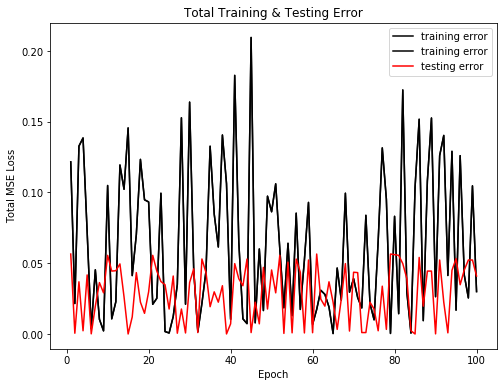

In [53]:
fig, ax = plt.subplots(figsize = (8,6))

epochs = np.arange(1, (num_epochs+1), 1)

plt.plot(epochs, train_epoch_losses, c = 'k', label = 'training error')
plt.plot(epochs, test_epoch_losses, c = 'r', label = 'testing error')
plt.legend(loc = 'upper right')
plt.title("Total Training & Testing Error")
ax.set_xlabel('Epoch')
ax.set_ylabel('Total MSE Loss')
plt.show()